# Create a CSV with each question answer

In [103]:
import pandas as pd
import json
import os

# Define the folder where your JSON files are located
folder_path = "Pilot Data"  

# Get a list of all JSON files in the folder
json_files = [f for f in os.listdir(folder_path) if f.endswith('.json')]

# Define the questions to track for "Your level of ..." and subscale categorization
your_level_questions = [
    "Your Level of Attention",
    "Your Level of Motivation",
    "Your Level of Muscular Fatigue of the Left Arm",
    "Your Level of Overall Tiredness"
]

subscale_questions = {
    "Executive": [
        "It was hard to work out how to complete the task successfully.",
        "It was difficult to keep my mind on the task."
    ],
    "Self-Initiation": [
        "I was continuously trying to perform the task better.",
        "I felt that I needed a push to continue tapping until the end of the task."
    ],
    "Emotional": [
        "I felt indifferent about my performance in the task.",
        "I felt satisfied when I saw that I was succeeding in the task."
    ]
}

# Helper function to inverse responses for negatively formulated questions
def inverse_response(response):
    return 6 - response  # Inverse mapping: 6 -> 0, 5 -> 1, 4 -> 2, etc.

# List to store data for the two CSVs
your_level_data = []
subscale_data = []

# Loop over all JSON files
for json_file in json_files:
    file_path = os.path.join(folder_path, json_file)
    
    # Load the JSON file
    with open(file_path, "r", encoding="utf-8") as file:
        data = json.load(file)

    # Keep a counter to track the block number for the questions
    block_counter = -1
    questions_in_block = 0
    participant_id = json_file.split("_")[1]
    condition = 'start'
    sync_block = -1
    async_block = -1

    # Enumerate over each entry in the JSON file to find the survey responses for the target questions
    for i, entry in enumerate(data):
        if entry.get("trial_type") == "survey-likert":
            response = entry.get("response", {})
            for question in response:
                # Check for "Your Level of ..." questions
                if question in your_level_questions:
                    # Backtrack to find the last trial with "blockType"
                    if condition == '':  # Find the condition
                        for j in range(i - 1, -1, -1):  # Iterate backwards
                            if "blockType" in data[j]:
                                condition = data[j]["blockType"]
                                break

                    your_level_data.append({
                        "participant_id": participant_id,
                        "block": block_counter,
                        "question": question,
                        "condition": condition,  
                        "response": int(response[question])  
                    })
                    questions_in_block += 1
                    if questions_in_block == 4 and block_counter == -1:
                        block_counter += 1
                        questions_in_block = 0  # Reset for the next block
                        condition = ''
                        sync_block = 0
                        async_block = 0
                    elif questions_in_block == 10:
                        block_counter += 1
                        questions_in_block = 0  # Reset for the next block
                        if condition == 'sync':
                            sync_block += 1
                        else:   
                            async_block += 1
                        condition = ''

                # Check for subscale questions and calculate inverse for negative questions
                for subscale, subscale_questions_list in subscale_questions.items():
                    if question in subscale_questions_list:
                                            # Backtrack to find the last trial with "blockType"
                        if condition == '':  # Find the condition
                            for j in range(i - 1, -1, -1):  # Iterate backwards
                                if "blockType" in data[j]:
                                    condition = data[j]["blockType"]
                                    break

                        if question in [
                            "It was hard to work out how to complete the task successfully.",
                            "It was difficult to keep my mind on the task.",
                            "I felt that I needed a push to continue tapping until the end of the task.",
                            "I felt indifferent about my performance in the task.",
                        ]:
                            # Inverse for negative formulation questions
                            actual_score = inverse_response(int(response[question]))
                        else:
                            # Normal score for positive formulation questions
                            actual_score = int(response[question])
                        
                        subscale_data.append({
                            "participant_id": participant_id,
                            "block": block_counter,
                            "condition_block_nr": sync_block if condition == 'sync' else async_block,
                            "question": question,
                            "subscale": subscale,
                            "condition": condition,  
                            "response": int(response[question]),
                            "actual_score": actual_score
                        })
                        questions_in_block += 1
                        if questions_in_block == 4 and block_counter == -1:
                            block_counter += 1
                            questions_in_block = 0  # Reset for the next block
                            condition = ''
                            sync_block = 0
                            async_block = 0
                        elif questions_in_block == 10:
                            block_counter += 1
                            questions_in_block = 0  # Reset for the next block
                            if condition == 'sync':
                                sync_block += 1
                            else:   
                                async_block += 1
                            condition = ''

                        
# Convert to DataFrames
df_your_level = pd.DataFrame(your_level_data)
df_subscale = pd.DataFrame(subscale_data)

# Export the DataFrames to CSV
df_your_level.to_csv(r"Pilot Data\your_level_responses.csv", index=False, encoding='utf-8')
df_subscale.to_csv(r"Pilot Data\subscale_responses.csv", index=False, encoding='utf-8')

print("CSV files generated successfully.")


CSV files generated successfully.


# Plot "your level of" over time per participant

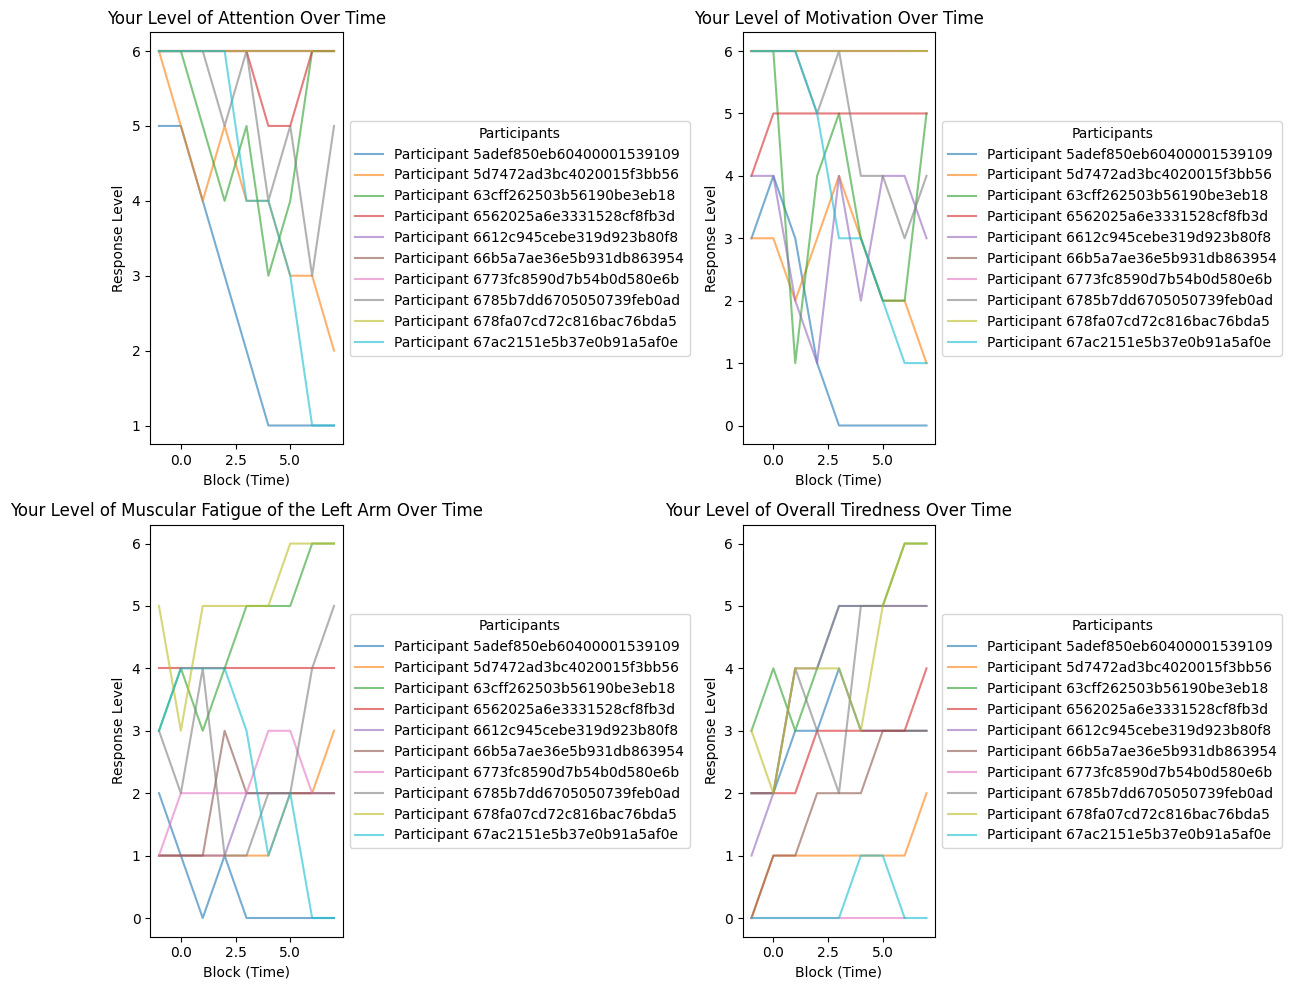

In [11]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file into a pandas DataFrame
df = pd.read_csv("Pilot Data/apathy_state_responses_with_participants.csv")  # Replace with the actual file path

# Filter for the "Your Level of ..." questions
questions_of_interest = ["Your Level of Attention", 
                         "Your Level of Motivation", 
                         "Your Level of Muscular Fatigue of the Left Arm", 
                         "Your Level of Overall Tiredness"]

# Filter the DataFrame for these questions
filtered_df = df[df['question'].isin(questions_of_interest)]

# Pivot the data so that each question becomes a column, and we can plot them easily
pivoted_df = filtered_df.pivot_table(
    index=['participant_id', 'block'], 
    columns='question', 
    values='response', 
    aggfunc='mean'
).reset_index()

# Create 4 subplots, one for each question
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()  # Flatten the axes array to easily loop through it

# Loop through each question and create a plot for it
for i, question in enumerate(questions_of_interest):
    ax = axes[i]
    
    # Loop through each participant and plot their responses for the current question
    for participant in pivoted_df['participant_id'].unique():
        participant_data = pivoted_df[pivoted_df['participant_id'] == participant]
        ax.plot(participant_data['block'], 
                participant_data[question], 
                label=f"Participant {participant}", alpha=0.6)
    
    # Set labels and title for the current subplot
    ax.set_xlabel('Block (Time)')
    ax.set_ylabel('Response Level')
    ax.set_title(f'{question} Over Time')
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Participants')

# Adjust layout to make sure everything fits
plt.tight_layout()

# Show the plots
plt.show()


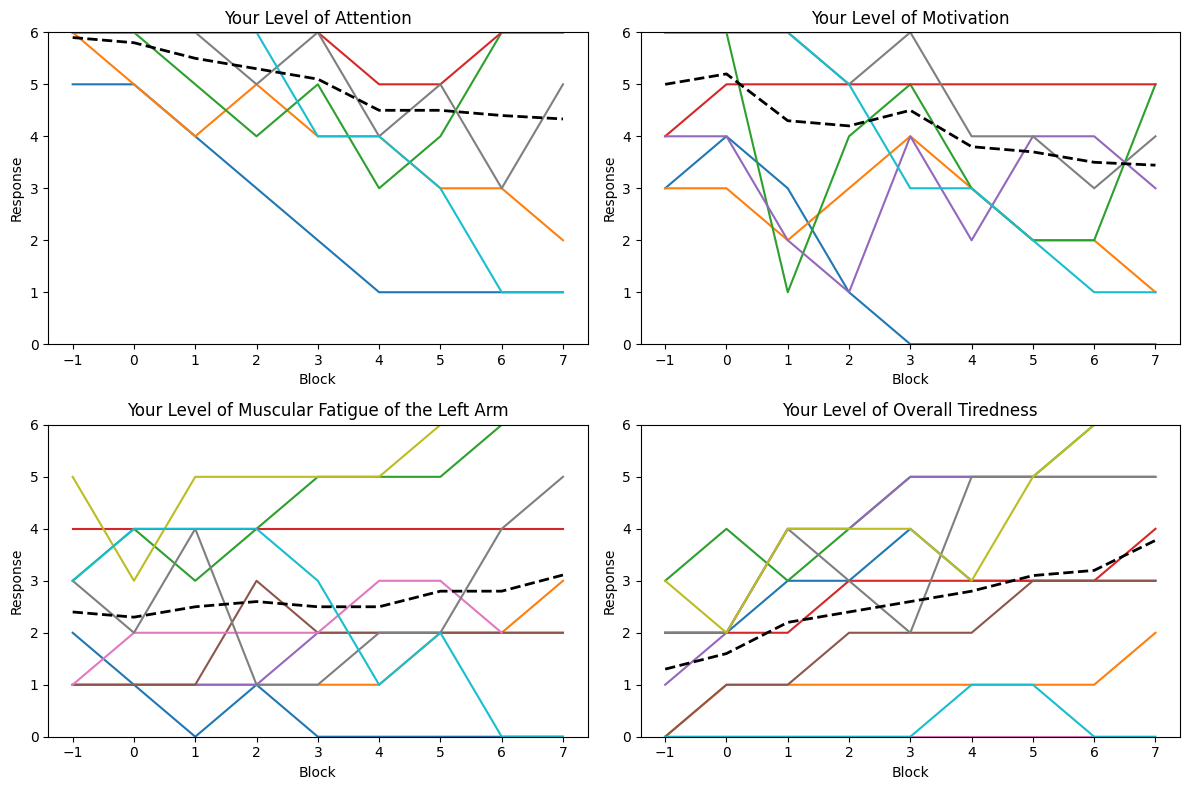

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

# Load the CSV file into a pandas DataFrame
df = pd.read_csv("Pilot Data/your_level_responses.csv")  # Replace with the actual file path

# Filter for the "Your Level of ..." questions
questions_of_interest = ["Your Level of Attention", 
                         "Your Level of Motivation", 
                         "Your Level of Muscular Fatigue of the Left Arm", 
                         "Your Level of Overall Tiredness"]

df_filtered = df[df['question'].isin(questions_of_interest)]

# Pivot the data to have one row per participant, block, and question, with responses as columns
df_pivoted = df_filtered.pivot_table(index=['participant_id', 'block'], 
                                     columns='question', 
                                     values='response', 
                                     aggfunc='first').reset_index()

# Plot each question with one line per participant
plt.figure(figsize=(12, 8))

for i, question in enumerate(questions_of_interest):
    plt.subplot(2, 2, i+1)  # Create 4 subplots (2x2)
    
    # Plot each participant's responses over time
    for participant in df_pivoted['participant_id'].unique():
        participant_data = df_pivoted[df_pivoted['participant_id'] == participant]
        plt.plot(participant_data['block'], participant_data[question], label=f'Participant {participant}')
    
    # Aggregate data (mean) for all participants
    mean_response = df_pivoted.groupby('block')[question].mean()
    plt.plot(mean_response.index, mean_response.values, label='Mean Response', color='black', linestyle='--', linewidth=2)
    
    # Title, labels, and axis limits
    plt.title(question)
    plt.xlabel('Block')
    plt.ylabel('Response')
    plt.ylim(0, 6)  # Set the y-axis range from 0 to 6

plt.tight_layout()
plt.show()


# Apathetic state per condition

In [108]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Load the CSV file into a pandas DataFrame
df = pd.read_csv("Pilot Data/subscale_responses.csv")  # Replace with the actual file path

# Step 1: Compute the total score for each participant and block
# Group by 'participant_id' and 'block', then sum the 'actual_score' values across all subscales
df_total_scores = df.groupby(['participant_id', 'condition_block_nr', 'condition'])['actual_score'].sum().reset_index()
# Rename the summed column to 'total_score'
df_total_scores.rename(columns={'actual_score': 'total_score'}, inplace=True)

# List of subscales to analyze
subscales = df['subscale'].unique()

# Initialize an empty list to store results for each subscale
results = []

# Loop over each subscale and fit a mixed-effects model
for subscale in subscales:
    # Filter the data for the current subscale
    subscale_data = df[df['subscale'] == subscale]
    
    # Fit the mixed-effects model for this subscale
    model = smf.mixedlm('actual_score ~ condition + condition_block_nr', 
                        data=subscale_data, 
                        groups=subscale_data['participant_id'])  
    result = model.fit()
    
    # Extract the summary
    summary = result.summary()
    
    # Save the relevant information for this subscale from the summary
    result_data = {
        'subscale': subscale,
        'coef_condition_sync': summary.tables[1].iloc[1, 1],  # Condition coefficient for sync
        'pvalue_condition_sync': summary.tables[1].iloc[1, 3],  # P-value for condition
        'coef_block': summary.tables[1].iloc[2, 1],  # Coefficient for block
        'pvalue_block': summary.tables[1].iloc[2, 3],  # P-value for block
    }
    
    # Append the results to the list
    results.append(result_data)

print(df_total_scores.head(10))
# Fit the mixed-effects model using the total score as the outcome variable
model_total = smf.mixedlm('total_score ~ condition + condition_block_nr', 
                          data=df_total_scores, 
                          groups=df_total_scores['participant_id']) 

result_total = model_total.fit()

# Extract the summary for the total score model
summary_total = result_total.summary()

# Save the relevant information for the total score model
result_data_total = {
    'subscale': 'Total Score',
    'coef_condition_sync': summary_total.tables[1].iloc[1, 1],  # Condition coefficient for sync
    'pvalue_condition_sync': summary_total.tables[1].iloc[1, 3],  # P-value for condition
    'coef_block': summary_total.tables[1].iloc[2, 1],  # Coefficient for block
    'pvalue_block': summary_total.tables[1].iloc[2, 3],  # P-value for block
}

# Append the total score results to the main list
results.append(result_data_total)

# Convert the results into a DataFrame
results_df = pd.DataFrame(results)

# Display the results
print(results_df)


             participant_id  condition_block_nr  condition  total_score
0  5adef850eb60400001539109                   0       sync           26
1  5adef850eb60400001539109                   0  wideasync           20
2  5adef850eb60400001539109                   1       sync           18
3  5adef850eb60400001539109                   1  wideasync           16
4  5adef850eb60400001539109                   2       sync           13
5  5adef850eb60400001539109                   2  wideasync           20
6  5adef850eb60400001539109                   3       sync           21
7  5adef850eb60400001539109                   3  wideasync           21
8  5d7472ad3bc4020015f3bb56                   0       sync           24
9  5d7472ad3bc4020015f3bb56                   0  wideasync           16
          subscale coef_condition_sync pvalue_condition_sync coef_block  \
0        Emotional               0.233                 0.068      0.105   
1        Executive               0.245                 0.0

In [110]:
import statsmodels.api as sm

X = df['block']
y = df['actual_score']
X = sm.add_constant(X)

model = sm.OLS(y, X).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:           actual_score   R-squared:                       0.026
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     12.44
Date:                Tue, 18 Mar 2025   Prob (F-statistic):           0.000462
Time:                        14:39:04   Log-Likelihood:                -972.79
No. Observations:                 474   AIC:                             1950.
Df Residuals:                     472   BIC:                             1958.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          4.2163      0.158     26.707      0.0

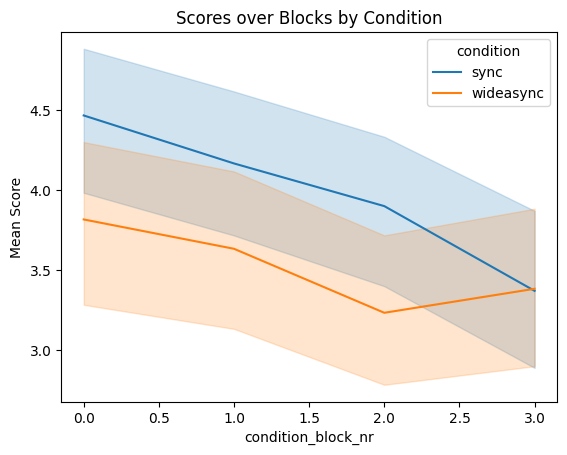

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot scores over blocks for each condition
sns.lineplot(data=df, x='condition_block_nr', y='actual_score', hue='condition', estimator='mean')
plt.xlabel('condition_block_nr')
plt.ylabel('Mean Score')
plt.title('Scores over Blocks by Condition')
plt.show()

# Correlation between Acceptance Rates and Self-Report Apathy score

In [82]:
import pandas as pd
import scipy.stats as stats


# Load the EBDM task data
df = pd.read_csv("Pilot Data/all_trials.csv")  # Replace with the actual file path

# Calculate the overall acceptance rate per block for each participant
block_acceptance_rate = df.groupby(['participant_id', 'block', 'delay'])['acceptance'].mean().reset_index()

# Rename the column to 'acceptance_rate'
block_acceptance_rate.rename(columns={'acceptance': 'acceptance_rate'}, inplace=True)

#print(block_acceptance_rate.head())

subscale_data = pd.read_csv("Pilot Data/subscale_responses.csv")  # Replace with the actual file path
# Calculate the average score per subscale for each participant per block
subscale_avg = subscale_data.groupby(['participant_id', 'block', 'subscale'])['actual_score'].sum().reset_index()

# Preview the aggregated subscale data
#print(subscale_avg.head())

# Merge the subscale averages with the block acceptance rates based on participant_id and block
merged_data = pd.merge(subscale_avg, block_acceptance_rate, on=['participant_id', 'block'])

# Preview the merged data
#print(merged_data.head())

# Initialize a dictionary to store correlation coefficients and p-values
correlation_results = {}

# Loop through each subscale and compute the correlation and p-value with acceptance rate
for subscale in merged_data['subscale'].unique():
    subscale_data = merged_data[merged_data['subscale'] == subscale]
    
    # Calculate Pearson's correlation coefficient and the p-value
    correlation, p_value = stats.pearsonr(subscale_data['actual_score'], subscale_data['acceptance_rate'])
    
    # Store the results
    correlation_results[subscale] = {'correlation': correlation, 'p_value': p_value}

# Display the results
print("Correlation between subscale scores and acceptance rates (with p-values):")
for subscale, results in correlation_results.items():
    print(f"{subscale}: Correlation = {results['correlation']:.3f}, p-value = {results['p_value']:.3f}")


# Group by participant_id and block, then sum the 'actual_score' values for each block
total_scores = subscale_avg.groupby(['participant_id', 'block'])['actual_score'].sum().reset_index()
total_scores.rename(columns={'actual_score': 'total_score'}, inplace=True)
print(total_scores.head())

# Step 2: Merge total scores with the EBDM acceptance rate data
# Merge on 'participant_id' and 'block'
merged_data = pd.merge(total_scores, block_acceptance_rate[['participant_id', 'block', 'acceptance_rate']], on=['participant_id', 'block'], how='left')
print(merged_data)

# Step 3: Calculate the overall correlation between total score and acceptance rate
# We now calculate the correlation across all blocks and participants
correlation, p_value = stats.pearsonr(merged_data['total_score'], merged_data['acceptance_rate'])

# Step 4: Display the results
print(f"Overall correlation between total score and acceptance rate: Correlation = {correlation:.3f}, p-value = {p_value:.3f}")

Correlation between subscale scores and acceptance rates (with p-values):
Emotional: Correlation = 0.598, p-value = 0.000
Executive: Correlation = 0.315, p-value = 0.005
Self-Initiation: Correlation = -0.027, p-value = 0.816
             participant_id  block  total_score
0  5adef850eb60400001539109      0           26
1  5adef850eb60400001539109      1           20
2  5adef850eb60400001539109      2           18
3  5adef850eb60400001539109      3           16
4  5adef850eb60400001539109      4           13
              participant_id  block  total_score  acceptance_rate
0   5adef850eb60400001539109      0           26         0.360000
1   5adef850eb60400001539109      1           20         0.160000
2   5adef850eb60400001539109      2           18         0.053333
3   5adef850eb60400001539109      3           16         0.000000
4   5adef850eb60400001539109      4           13         0.000000
..                       ...    ...          ...              ...
74  67ac2151e5b37e0b91a5a